In [51]:
#importation des librairies

%matplotlib inline
import pymysql as sql
import pandas as pd 
import os

import numpy as np

import folium
from folium import plugins
import seaborn as sns
import matplotlib.pyplot as plt

from geopy import Nominatim
import folium
from folium import plugins
from folium import Choropleth, Marker
from folium.plugins import MarkerCluster

# Enjolive les graphes
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

**************************************************************
*****************Connection à la BDD**************************

In [52]:
# Se Connecter à la BDD foody
conn = sql.connect(host='Localhost',user='root',passwd='Portes1907*', database='foody')
if conn:
    print("Connection Successful!")
else:
    print("Connection Failed!")
cur = conn.cursor()
#cur.execute("SHOW DATABASES")
cur.execute("select * from categorie limit 10")
for row in cur:
    print(row)
#TBD

Connection Successful!
(1, 'drinks', 'Soft drinks, coffees, teas, beers, and ales')
(2, 'Condiments', 'Sweet and savory sauces, relishes, spreads, and seasonings')
(3, 'Desserts', 'Desserts, candies, and sweet breads')
(4, 'Dairy Products', 'Cheeses')
(5, 'Grains/Cereals', 'Breads, crackers, pasta, and cereal')
(6, 'Meat/Poultry', 'Prepared meats')
(7, 'Produce', 'Dried fruit and bean curd')
(8, 'Seafood', 'Seaweed and fish')


In [53]:
# définir la fct sql_to_pandas

def sql_to_df(sql_query):

    # Use pandas to pass sql query using connection form SQLite3
    df = pd.read_sql(sql_query, conn)

    # Show the resulting DataFrame
    return df

********************************************************
*********************VISUALISATION**********************
********************************************************

***********#Quelle est la répartition des commandes par pays ? **********

In [54]:
#Quelle est la répartition des commandes par pays ? 


query=''' SELECT distinct Pays, count(NoCom) as "nombre de commande" 
FROM foody.client natural join commande group by Pays order by 2 desc; '''

def1= sql_to_df(query)

def1

,Pays,nombre de commande
0,Germany,122
1,USA,122
2,Brazil,83
3,France,77
4,UK,56
5,Venezuela,46
6,Austria,40
7,Sweden,37
8,Canada,30
9,Mexico,28


<AxesSubplot:xlabel='Pays', ylabel='nombre de commande'>

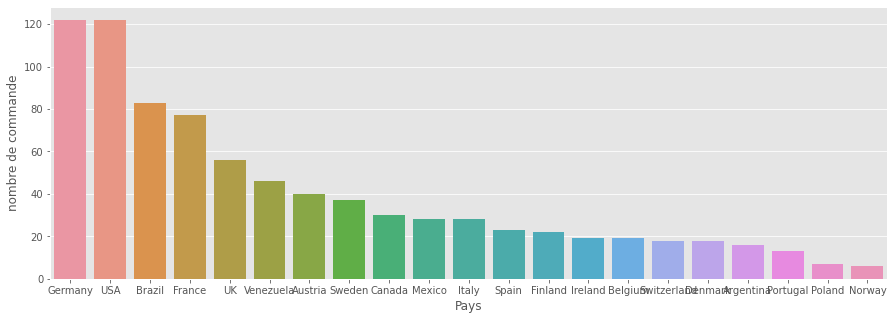

In [55]:
#graphe
sns.barplot(x='Pays', y='nombre de commande', data=def1)

**************************************************
***************Etat des livraisons ***************
**************************************************

In [56]:
#Indiquer pour les commandes envoyées si elles ont été envoyées en retard 
#(date d'envoi DateEnv supérieure (ou égale) à la date butoir ALivAvant) ou à temps
#REMARQUE : j'ai mis non livré car il y a des nuls dans DateEnv


query=''' select PaysLiv , DateCom, AlivAvant, DateEnv,
	CASE 
		WHEN (DateEnv >= AlivAvant) THEN " En retard"
        WHEN (DateEnv < AlivAvant) THEN " Dans les temps"
		ELSE " Non livré"
END AS Statutlivraison
FROM foody.commande; '''

def2= sql_to_df(query)

def2





,PaysLiv,DateCom,AlivAvant,DateEnv,Statutlivraison
0,France,2006-07-04,2006-08-01,2006-07-16,Dans les temps
1,Germany,2006-07-07,2006-08-16,2006-07-10,Dans les temps
2,Brazil,2006-07-08,2006-08-05,2006-07-12,Dans les temps
3,France,2006-07-08,2006-08-05,2006-07-15,Dans les temps
4,Belgium,2006-07-09,2006-08-06,2006-07-11,Dans les temps
...,...,...,...,...,...
825,Mexico,2008-05-05,2008-06-02,NaT,Non livré
826,Denmark,2008-05-06,2008-06-03,NaT,Non livré
827,Switzerland,2008-05-06,2008-06-03,NaT,Non livré
828,France,2008-05-06,2008-06-03,NaT,Non livré


<AxesSubplot:xlabel='Statutlivraison', ylabel='PaysLiv'>

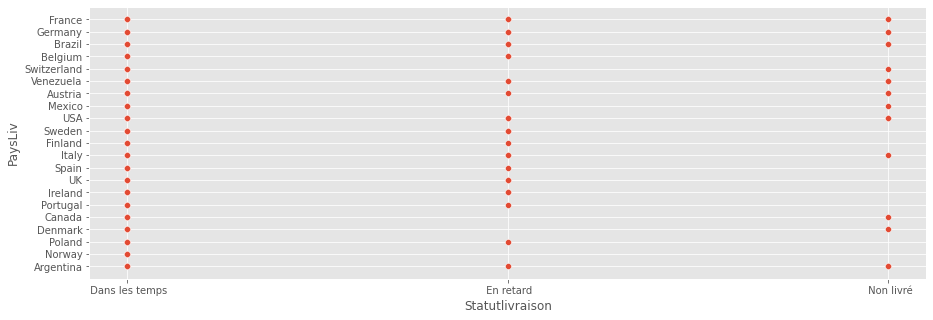

In [57]:
sns.scatterplot(x='Statutlivraison', y='PaysLiv', data=def2)

******************************************************
*************Delai de livraison par pays**************
*****************************************************

In [58]:
#delai de livraison en jours par pays ?

query=''' select PaysLiv as "Pays de livraison" , round(AVG(Datediff(DateEnv,DateCom))) as "delai de livraison en jours"
FROM foody.commande group by PaysLiv order by 2 desc; '''

def3= sql_to_df(query)

def3

,Pays de livraison,delai de livraison en jours
0,Ireland,11.0
1,Switzerland,10.0
2,USA,10.0
3,Sweden,10.0
4,Belgium,9.0
5,Austria,9.0
6,Spain,9.0
7,Portugal,9.0
8,Argentina,9.0
9,France,8.0


In [59]:
def3.dropna(inplace=True)

<AxesSubplot:xlabel='delai de livraison en jours', ylabel='Pays de livraison'>

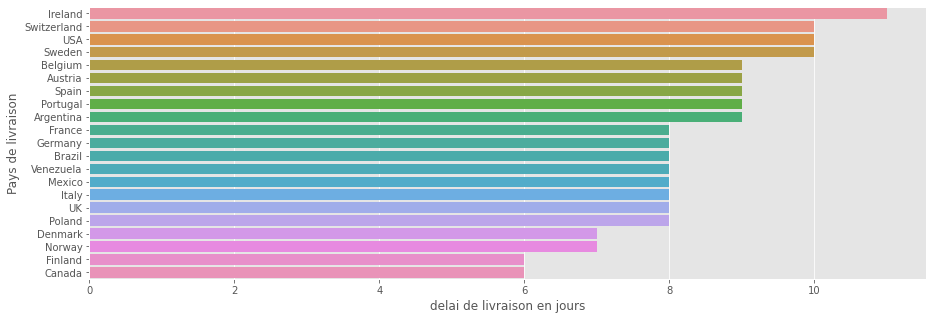

In [60]:
sns.barplot(x='delai de livraison en jours', y='Pays de livraison',data=def3)

In [61]:
#connection API myGeocoder
geolocator = Nominatim(user_agent="myGeocoder")

In [62]:
#funtion to transform physical adress into Long/Lag/Alt

def convert_to_LongLag(df):
  
    df['location'] = df['Pays de livraison'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
    df[['latitude', 'longitude']] = pd.DataFrame(df['location'].tolist(),index=df.index) #split location column
    df.drop(['location'], axis=1, inplace=True)
    return df

convert_to_LongLag(def3)

,Pays de livraison,delai de livraison en jours,latitude,longitude
0,Ireland,11.0,52.865196,-7.979460
1,Switzerland,10.0,46.798562,8.231974
2,USA,10.0,39.783730,-100.445882
3,Sweden,10.0,59.674971,14.520858
4,Belgium,9.0,50.640281,4.666715
5,Austria,9.0,47.200000,13.200000
6,Spain,9.0,39.326068,-4.837979
7,Portugal,9.0,40.033263,-7.889626
8,Argentina,9.0,-34.996496,-64.967282
9,France,8.0,46.603354,1.888334


In [63]:
#Create a map
m = folium.Map(location=[37.435998, -39.480053],tiles='openstreetmap',zoom_start=3)

#Creation of clusters and subgroup
mcg = MarkerCluster(control=False)
m.add_child(mcg)

g3 = folium.plugins.FeatureGroupSubGroup(mcg,'Pays de livraison')
m.add_child(g3)

#remplissage de la carte
for idx, row in def3.iterrows():
    Marker([row['latitude'], row['longitude']],popup= row['Pays de livraison']+ " Délai de livraison : " + str(row['delai de livraison en jours']),
          icon=plugins.BeautifyIcon(text_color='#650a21')).add_to(g3)

folium.LayerControl(collapsed=True).add_to(m)
m.save('CarteDDL.html')
m

******************************************************
********Volume des commandes par mois *****************
******************************************************

In [64]:
#Mois où il y a le plus de commande

query=''' select month(DateCom) as "mois de commande", count(NoCom) as "nombre de commande" 
FROM foody.commande group by month(DateCom) order by 2 desc; '''

def5= sql_to_df(query)

def5

,mois de commande,nombre de commande
0,4,105
1,3,103
2,1,88
3,2,83
4,12,79
5,10,64
6,9,60
7,11,59
8,8,58
9,7,55


<AxesSubplot:xlabel='mois de commande', ylabel='nombre de commande'>

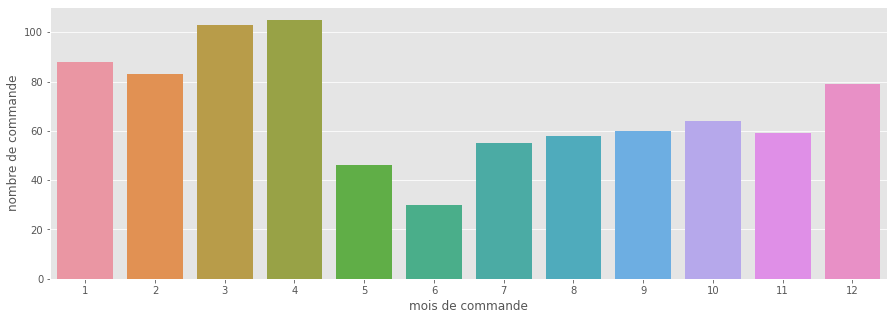

In [65]:
sns.barplot(x='mois de commande',y='nombre de commande',data=def5)

********************************************************************************************************
*****************************Map avec la livraison à temps ou en retard dans les villes*********************************
********************************************************************************************************

In [66]:
query= '''SELECT Villeliv, COUNT(Statutlivraison) AS 'En retard'
FROM (
    select VilleLiv , DateCom, AlivAvant, DateEnv,
        CASE 
            WHEN (DateEnv >= AlivAvant) THEN " En retard"
            WHEN (DateEnv < AlivAvant) THEN " Dans les temps"
            ELSE " Non livré"
    END AS Statutlivraison
    FROM foody.commande) AS temporaire
WHERE Statutlivraison = " En retard"
GROUP BY Villeliv;'''

df_r= sql_to_df(query)
df_r

,VilleLiv,En retard
0,Brcke,1
1,Lander,1
2,Lule,2
3,Charleroi,1
4,Cork,3
5,Oulu,1
6,Campinas,3
7,Salzburg,1
8,Lisboa,1
9,Cunewalde,3


In [67]:
query=''' SELECT Villeliv, COUNT(Statutlivraison) AS ' Dans les temps'
FROM (
    select VilleLiv , DateCom, AlivAvant, DateEnv,
        CASE 
            WHEN (DateEnv >= AlivAvant) THEN " En retard"
            WHEN (DateEnv < AlivAvant) THEN " Dans les temps"
            ELSE " Non livré"
    END AS Statutlivraison
    FROM foody.commande) AS temporaire
WHERE Statutlivraison = " Dans les temps"
GROUP BY Villeliv;'''


df_t= sql_to_df(query)
df_t

,VilleLiv,Dans les temps
0,Reims,5
1,Mnster,6
2,Rio de Janeiro,33
3,Lyon,10
4,Charleroi,11
...,...,...
65,Butte,3
66,Berlin,6
67,Campinas,6
68,Paris,4


In [68]:
replace_f = {'Genve':'Geneve', 'Gteborg':'Goteborg','Brcke':'Bräcke','Mxico':'Mexico','Tsawassen':'Tsawwassen','San Cristbal':'San Cristobal',
             'Warszawa':'Warsaw','Montral':'Montreal','Mnster':'Münster','rhus':'Aarhus'}

In [69]:
df_t['VilleLiv'].replace(replace_f, regex=True, inplace=True)

In [70]:
df_r['VilleLiv'].replace(replace_f, regex=True, inplace=True)

In [71]:
#connection API myGeocoder
geolocator = Nominatim(user_agent="myGeocoder")

In [72]:
df_t

,VilleLiv,Dans les temps
0,Reims,5
1,Münster,6
2,Rio de Janeiro,33
3,Lyon,10
4,Charleroi,11
...,...,...
65,Butte,3
66,Berlin,6
67,Campinas,6
68,Paris,4


In [73]:
df_r

,VilleLiv,En retard
0,Bräcke,1
1,Lander,1
2,Lule,2
3,Charleroi,1
4,Cork,3
5,Oulu,1
6,Campinas,3
7,Salzburg,1
8,Lisboa,1
9,Cunewalde,3


In [74]:
def convert_to_LongLag(df):
  
    df['location'] = df['VilleLiv'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
    df[['latitude', 'longitude']] = pd.DataFrame(df['location'].tolist(),index=df.index) #split location column
    df.drop(['location'], axis=1, inplace=True)
    return df


convert_to_LongLag(df_t)


,VilleLiv,Dans les temps,latitude,longitude
0,Reims,5,49.257789,4.031926
1,Münster,6,51.962510,7.625188
2,Rio de Janeiro,33,-22.911014,-43.209373
3,Lyon,10,45.757814,4.832011
4,Charleroi,11,50.412033,4.443624
...,...,...,...,...
65,Butte,3,39.651927,-121.585844
66,Berlin,6,52.517037,13.388860
67,Campinas,6,-22.905560,-47.060830
68,Paris,4,48.856697,2.351462


In [75]:
convert_to_LongLag(df_r)

,VilleLiv,En retard,latitude,longitude
0,Bräcke,1,62.783333,15.666667
1,Lander,1,39.905988,-116.984337
2,Lule,2,20.753345,74.498958
3,Charleroi,1,50.412033,4.443624
4,Cork,3,51.898627,-8.470594
5,Oulu,1,65.011873,25.471681
6,Campinas,3,-22.905560,-47.060830
7,Salzburg,1,47.798135,13.046481
8,Lisboa,1,38.707751,-9.136592
9,Cunewalde,3,51.098481,14.514475


In [76]:
df_t

,VilleLiv,Dans les temps,latitude,longitude
0,Reims,5,49.257789,4.031926
1,Münster,6,51.962510,7.625188
2,Rio de Janeiro,33,-22.911014,-43.209373
3,Lyon,10,45.757814,4.832011
4,Charleroi,11,50.412033,4.443624
...,...,...,...,...
65,Butte,3,39.651927,-121.585844
66,Berlin,6,52.517037,13.388860
67,Campinas,6,-22.905560,-47.060830
68,Paris,4,48.856697,2.351462


In [77]:
#Create a map
m = folium.Map(location=[37.435998, -39.480053],tiles='openstreetmap',zoom_start=3)

#Creation of clusters and subgroup
mcg = MarkerCluster(control=False)
m.add_child(mcg)

g3 = folium.plugins.FeatureGroupSubGroup(mcg,'Délais de livraisons')
m.add_child(g3)

g1 = folium.plugins.FeatureGroupSubGroup(mcg,'En retard')
m.add_child(g1)

g2 = folium.plugins.FeatureGroupSubGroup(mcg,'Dans les temps')
m.add_child(g2)

#remplissage de la carte
for idx, row in def3.iterrows():
    Marker([row['latitude'], row['longitude']],popup= row['Pays de livraison']+ " Délai de livraison : " + str(row['delai de livraison en jours']),
          icon=plugins.BeautifyIcon(text_color='#650a21')).add_to(g3)
    
for idx, row in df_t.iterrows():
    Marker([row['latitude'], row['longitude']],popup= row['VilleLiv']+ " Livraison dans les temps : " + str(row['Dans les temps']),
          icon=plugins.BeautifyIcon(text_color='#650a21')).add_to(g2)
    
for idx, row in df_r.iterrows():
    Marker([row['latitude'], row['longitude']],popup= row['VilleLiv']+ " Livraison dans les temps : " + str(row['En retard']),
          icon=plugins.BeautifyIcon(text_color='#650a21')).add_to(g1)

folium.LayerControl(collapsed=True).add_to(m)
m.save('CarteR.html')
m